In [1]:
import sys
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


def FFT(n_harm,stock,date_0,date_1,date_2):
    
    data = yf.Ticker(stock).history(start=date_0, end=date_1)
    price = data['Close']
    x = np.array(price)
    data2 = yf.Ticker(stock).history(start=date_0, end=date_2)
    price2 = data2['Close']
    x2 = np.array(price2)
    n_predict = price2.size - price.size
    n_x = x.size
    t = np.arange(0, n_x)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x

    x_freqdom = fft.fft(x_notrend,n = n_x)        
    f = fft.fftfreq(n_x)
    mask = np.where(f >= 0)
    indexes = list(range(n_x))             # frequencies
    indexes.sort(key = lambda i: np.absolute(f[i]))  # sort indexes by frequency, lower -> higher
    t = np.arange(0, n_x + n_predict)
    restored_sig = np.zeros(t.size)
    count = 0
    for i in indexes[1:1 + n_harm * 2]:
        if (count <= 100 or count >= (n_harm * 2 -2)): 
            if(count % 2 == 0):
                ampli = np.absolute(x_freqdom[i]) / n_x   # amplitude
                phase = np.angle(x_freqdom[i])            # phase
                signal = ampli * np.cos(2 * np.pi * f[i] * t + phase)
                restored_sig += signal
            count += 1
    signal = restored_sig
    
    df = pd.DataFrame()
    df.index = price2.index
    df['signal'] = signal
    # df = df.drop(df[df.index < date_1].index)
    return df


In [2]:
def peak_valleys_delay(pv_1,pv_2):
    import datetime
    data3 = pd.DataFrame()
    data3['peaks_1'] = pv_1['peaks']
    data3 = data3.dropna(how='all') 
    li_peak_1 = list(data3['peaks_1'].index)
    data4 = pd.DataFrame()
    data4['peaks_2'] = pv_2['peaks']
    data4 = data4.dropna(how='all') 
    li_peak_2 = list(data4['peaks_2'].index)
    li_peak = []
    for i in range(0,len(li_peak_2)): 
        temp = []
        temp_abs = []
        temp2 = []
        for j in range(0,len(li_peak_1)): 
            temp.append((li_peak_1[j] - li_peak_2[i]).days)
            temp_abs.append(abs(li_peak_1[j] - li_peak_2[i]).days)
        for k in range(0,len(temp_abs)):
            if temp_abs[k] == min(temp_abs) : 
                temp2 = temp[k]
        li_peak.append(temp2)
    data4['delay'] = li_peak

    data5 = pd.DataFrame()
    data5['valleys_1'] = pv_1['valleys']
    data5 = data5.dropna(how='all') 
    li_valley_1 = list(data5['valleys_1'].index)
    data6 = pd.DataFrame()
    data6['valleys_2'] = pv_2['valleys']
    data6 = data6.dropna(how='all') 
    li_valley_2 = list(data6['valleys_2'].index)
    li_valley = []
    for i in range(0,len(li_valley_2)): 
        temp = []
        temp_abs = []
        temp2 = []
        for j in range(0,len(li_valley_1)): 
            temp.append((li_valley_1[j] - li_valley_2[i]).days)
            temp_abs.append(abs(li_valley_1[j] - li_valley_2[i]).days)
        for k in range(0,len(temp_abs)):
            if temp_abs[k] == min(temp_abs) : 
                temp2 = temp[k]
        li_valley.append(temp2)
    data6['delay'] = li_valley
    return data4['delay'],data6['delay']

In [3]:
def peak_valleys(pv_range,data):
    pd.options.mode.chained_assignment = None
    try :
        pv = data['Close']
    except :
        pv = data['signal']

    data['peaks'] = pd.Series(dtype='float64') 
    data['valleys'] = pd.Series(dtype='float64') 
    peaks = data['peaks']
    valleys = data['valleys']

    for idx in range(0, len(pv)):
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].max():
            peaks.iloc[idx] = pv[idx]
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].min():
            valleys.iloc[idx] = pv[idx]
    return peaks,valleys

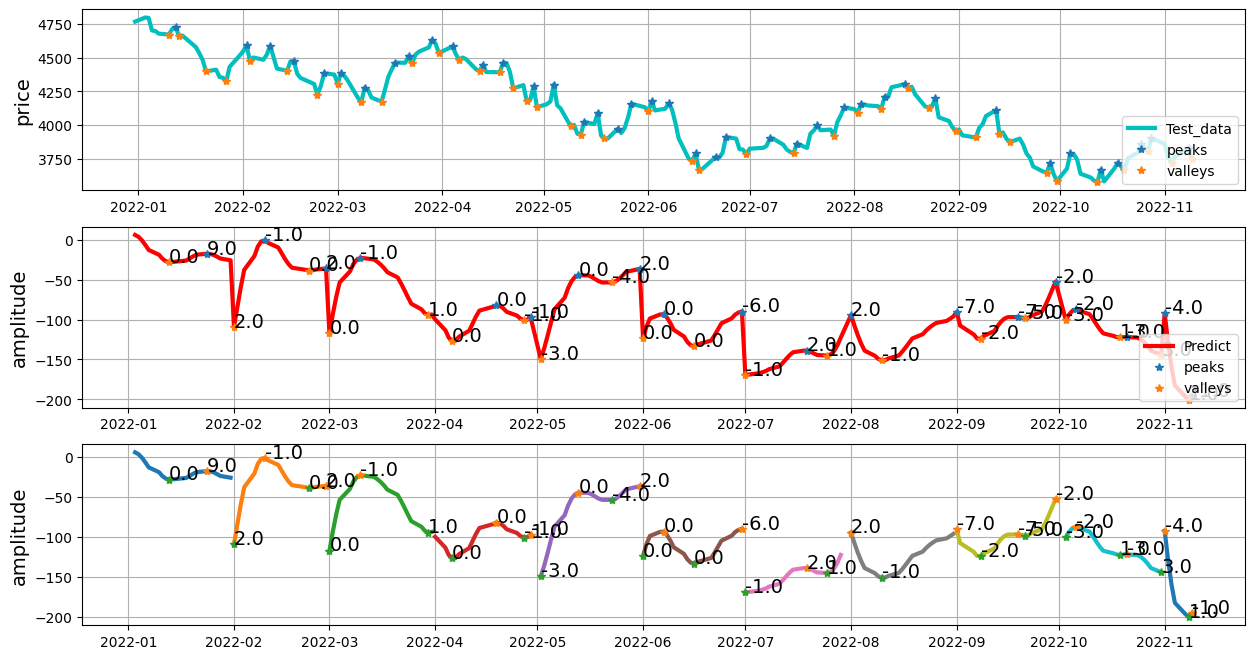

In [6]:
import datetime
from dateutil.relativedelta import relativedelta
 
stock = "^GSPC"
date_0 = datetime.datetime(2021, 1, 1)
date_0 = date_0 + relativedelta(months=-2)
date_start = date_0 + relativedelta(months=+14)


df = pd.DataFrame()
fig, axes = plt.subplots(3, 1, figsize=(15, 8))
for i in range(11) :
    date_0 = date_0 + relativedelta(months=+1)
    date_0_1 = date_0 + relativedelta(months=+1)
    date_1 = date_0 + relativedelta(months=+13)
    date_2 = date_0 + relativedelta(months=+14)
    df3 = FFT(20,stock,date_0,date_1,date_2)
    # axes[2].plot(df3[df3.index < date_1].index, df3['signal'][df3.index < date_1], linewidth=3, label='Test_data')
    # axes[3].plot(df3[df3.index < date_0_1].index, df3['signal'][df3.index < date_0_1], linewidth=3, label='Test_data')
    df2 = df3.drop(df3[df3.index < date_1].index)

    axes[2].plot(df2.index, df2['signal'], label='Predict',linewidth=3)
    df = pd.concat([df,df2])
date_end = date_2

data = yf.Ticker(stock).history(start=date_start, end=date_end)
pv_range = 2
data['peaks'] = peak_valleys(pv_range,data)[0]
data['valleys'] = peak_valleys(pv_range,data)[1]
df['peaks'] = peak_valleys(pv_range,df)[0]
df['valleys'] = peak_valleys(pv_range,df)[1]
df['peaks_delay'] = peak_valleys_delay(data,df)[0]
df['valleys_delay'] = peak_valleys_delay(data,df)[1]
# fig, axes = plt.subplots(3, 1, figsize=(15, 8))
axes[0].plot(data.index, data['Close'], 'c', linewidth=3, label='Test_data')
axes[0].set_ylabel("price", fontsize=14)
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[1].set_ylabel("amplitude", fontsize=14)
axes[2].set_ylabel("amplitude", fontsize=14)
axes[1].plot(df.index, df['signal'],'r', label='Predict',linewidth=3)
axes[0].plot(data.index,data['peaks'],'*',label='peaks')
axes[0].plot(data.index,data['valleys'],'*',label='valleys')
axes[1].plot(df.index , df['peaks'],'*',label='peaks')
axes[1].plot(df.index , df['valleys'],'*',label='valleys')
axes[2].plot(df.index , df['peaks'],'*',label='peaks')
axes[2].plot(df.index , df['valleys'],'*',label='valleys')
for i, label in enumerate(df['peaks_delay']):
    axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
for i, label in enumerate(df['valleys_delay']):
    axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
for i, label in enumerate(df['peaks_delay']):
    axes[2].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
for i, label in enumerate(df['valleys_delay']):
    axes[2].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
axes[0].legend(loc=4)
axes[1].legend(loc=4)
plt.show()

# data2 = yf.Ticker(stock).history(start=datetime.datetime(2000, 1, 1), end=datetime.datetime(2002, 1, 1))
# pl.plt.figure(figsize=(15,4))
# plt.plot(data2.index, data2['Close'],'c', linewidth=3, label='Test_data')
# plt.show()



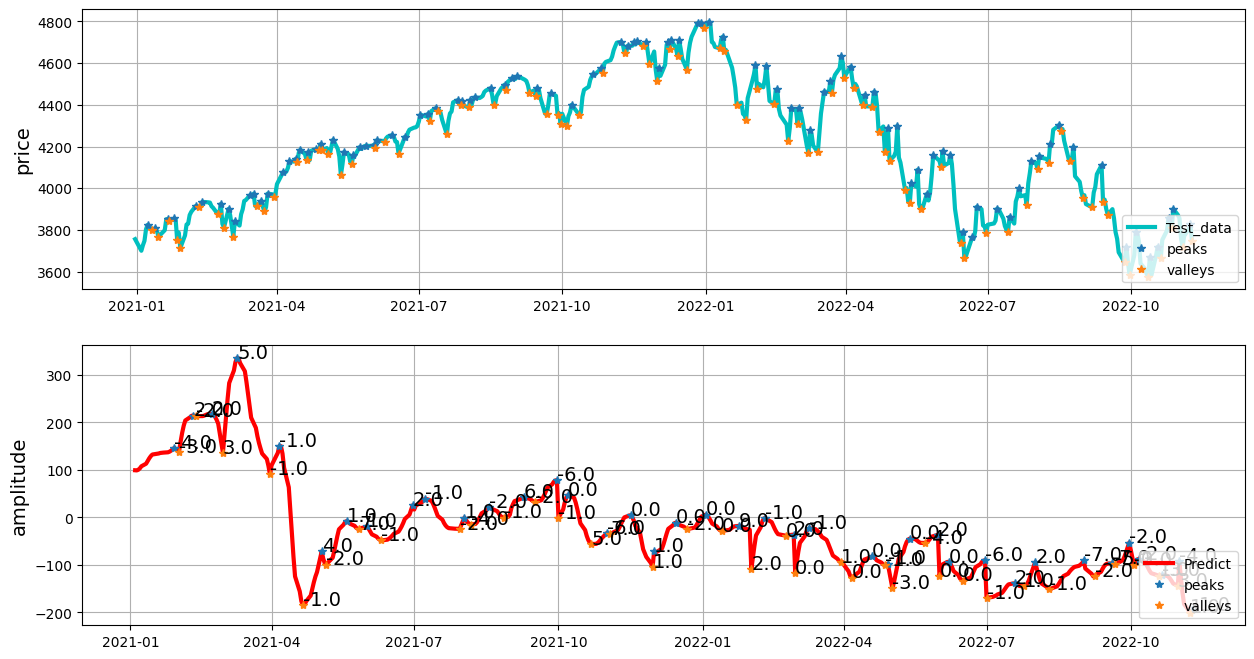

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].plot(data.index, data['Close'], 'c', linewidth=3, label='Test_data')
axes[0].set_ylabel("price", fontsize=14)
axes[0].grid(True)
axes[1].plot(df.index, df['signal'], 'r', label='Predict',linewidth=3)
axes[1].grid(True)
axes[1].set_ylabel("amplitude", fontsize=14)
axes[0].plot(data.index,data['peaks'],'*',label='peaks')
axes[0].plot(data.index,data['valleys'],'*',label='valleys')
axes[1].plot(df.index , df['peaks'],'*',label='peaks')
axes[1].plot(df.index , df['valleys'],'*',label='valleys')
for i, label in enumerate(df['peaks_delay']):
    axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
for i, label in enumerate(df['valleys_delay']):
    axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)

axes[0].legend(loc=4)
axes[1].legend(loc=4)
plt.show()
